In [ ]:
import numpy as np
import os
import torch
import os
import augment
import torch.utils.data.dataset as dataset
import matplotlib.pyplot as plt

In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset
import gc

class MMapDataset(Dataset):
    def __init__(self, names, path='../data/hm30rad/', aug_params=None, gpu=False):
        src_dir=os.path.join(path,'src')
        tgt_dir=os.path.join(path,'tgt')
        self.src_files = [os.path.join(src_dir,f"{f}.npy") for f in names]
        self.tgt_files = [os.path.join(tgt_dir,f"{f}.npy") for f in names]
        if aug_params is None:
            self.aug_params = {
                "patch_size": (100,100,100),
                "final_size":   (100,100,100),
                "flip_prob":  0.5,
                "rot_prob":   0.5,
                "scale_prob": 1.0,
                "rot_range":  np.pi,
                "scale_range": 0.2
            }
        else: self.aug_params = aug_params
        self.gpu = gpu

    def __len__(self):
        return len(self.src_files)

    def __getitem__(self, idx):
        sample = {
            'src': np.load(self.src_files[idx], mmap_mode='r'),
            'tgt': np.load(self.tgt_files[idx], mmap_mode='r'),
        }
        
        aug = augment.rand_aug(
            sample=sample,
            aug_params=self.aug_params,
            gpu=self.gpu
        )
        
        for key in aug.keys():
            del sample[key]
            gc.collect()
        return aug

# Custom collate function
def custom_collate(batch):
    src = torch.stack([sample['src'] for sample in batch])
    tgt = torch.stack([sample['tgt'] for sample in batch])
    return {'src': src, 'tgt': tgt}

KeyboardInterrupt: 

In [ ]:
#mmap testing
batch = ['tomo_003acc','tomo_00e047','tomo_00e463','tomo_033ebe']
src_path = '../data/hm30rad/src/'
tgt_path = '../data/hm30rad/tgt/'

aug_params = {
    "patch_size": (100,100,100),
    "final_size":   (100,100,100),
    "flip_prob":  0.5,
    "rot_prob":   0.5,
    "scale_prob": 1.0,
    "rot_range":  np.pi,
    "scale_range": 0.2
}

In [ ]:
def tuple_op(operator, tuple1, tuple2):
    if len(tuple1) != len(tuple2):
        raise ValueError("Tuples must have the same length")
    
    # Apply the operator element-wise using zip and a list comprehension
    return tuple(operator(x, y) for x, y in zip(tuple1, tuple2))

In [ ]:
import numpy as np
import random
from monai.transforms import MapTransform
import gc

class RandCropMMapd(MapTransform):
    def __init__(self, keys, roi_size):
        super().__init__(keys)
        self.roi_size = roi_size

    def __call__(self, data):
        d = dict(data)
        #get random nums
        shapes = [data[self.keys[0]][i].shape for i in range(len(data['src']))]
        ranges = [tuple_op(lambda x,y: x-y, shape, self.roi_size) for shape in shapes]
        start  = [tuple(random.randint(0, r[i]) for i in range(3)) for r in ranges]
        stop   = [tuple_op(lambda x,y: x+y, s, self.roi_size) for s in start]
        result = {}
        for key in self.keys:
            crops = [data[key][i][tuple(slice(j, k) for j, k in zip(start[i], stop[i]))].copy() for i in range(len(data[key]))]
            result[key] = np.expand_dims(np.stack(crops), axis=1)
        return result

In [ ]:
rand_crop = RandCropMMapd(keys=['src','tgt'], roi_size=(100,100,100))
# sample = {
#     'src':[np.load(os.path.join(src_path,f'{f}.npy'), mmap_mode='r') for f in batch],
#     'tgt':[np.load(os.path.join(tgt_path,f'{f}.npy'), mmap_mode='r') for f in batch]
# }

sample = {
    'src': np.load(os.path.join(src_path,f'{batch[0]}.npy'), mmap_mode='r'),
    'tgt': np.load(os.path.join(tgt_path,f'{batch[0]}.npy'), mmap_mode='r')
}

result=augment.rand_aug(sample=sample, aug_params=aug_params)
# result = rand_crop(sample)
for key in result.keys():
    del sample[key]
    gc.collect()

In [ ]:
result['src'].dtype

torch.float32

torch.Size([1, 100, 100, 100])

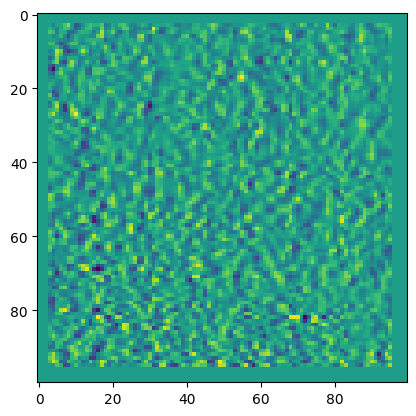

In [ ]:
plt.imshow(result['src'][0,10,:,:].cpu(), cmap='viridis')
result['src'].shape


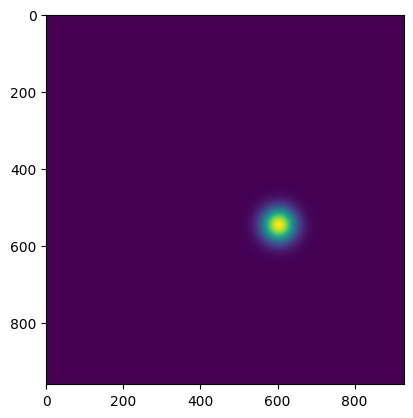

In [5]:
import numpy as np
import matplotlib.pyplot as plt

src_path = '../data/hm30rad/src/tomo_00e047.npy'
tgt_path = '../data/hm30rad/tgt/tomo_00e047.npy'

src = np.load(src_path)
tgt = np.load(tgt_path)
plt.imshow(tgt[169,:,:], cmap='viridis')

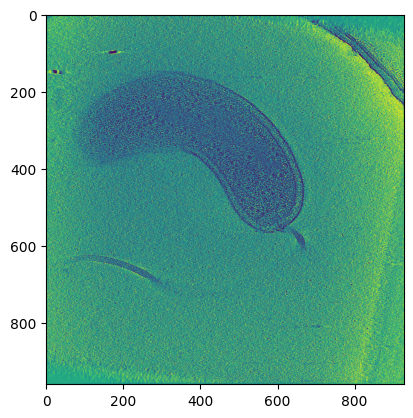

In [6]:
plt.imshow(src[169,:,:], cmap='viridis')

In [ ]:
import dataloader
scheduler = dataloader.Scheduler(warmup_epochs=5, warmup_value=0.75,init_value=5.0,factor=1.1,stop=10)
for i in range(30):
    print(f'{scheduler():.4f}')
    scheduler.step()

0.75
0.75
0.75
0.75
5.0
5.5
6.050000000000001
6.655000000000001
7.320500000000002
8.052550000000002
8.857805000000003
9.743585500000004
10.717944050000005
11.789738455000007
12.968712300500009
14.26558353055001
15.692141883605013
17.261356071965515
18.98749167916207
20.886240847078277
22.974864931786108
25.27235142496472
27.799586567461198
30.57954522420732
33.63749974662805
37.00124972129086
40.70137469341995
44.77151216276195
49.24866337903815
54.17352971694197
